<a href="https://colab.research.google.com/github/yaqianhuang/Case-Studies-Kramer-Eden/blob/master/Intro_WS_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OEAW AI Winter School 2025 - Day 1

## Introduction to Deep Learning - *My first Neural Network*

This notebook serves as a sanity check whether everything works on your computer and gives a feeling on how to implement the training of a neural network. Please follow these steps:



1.   Save a copy of this notebook to your own Drive, as you will not be able to edit this one.
2.   Walk through *Part I.* of the notebook. Run each of the cells (you can press Crtl/Cmd + Enter to do this) and try to understand what is going on in the code (it is alright not to understand the specifics of Python just yet - the comments are there to help you). If any of the cells runs into an error, please let us know so we can sort it out.
3.    Take a look at the exercises in *Part II.* of the notebook. They are to test your understanding of ML concepts and coding skills. Feel free to do them now or come back to them later. If you get stuck, we are here to help.

Good luck, and happy learning!

# *Part I.*

This section contains code already written for you, which implements a neural network and trains (and tests) it on an image dataset. Let's start by importing the libraries needed for these tasks...

In [1]:
# Importing Python libraries used in the notebook.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import savgol_filter
%config InlineBackend.figure_formats = ['svg']
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.models import VGG

## Hyperparameters for the Training Procedure

This cell prepares the training procedure by specifying some arguments and setting the correct computational environment.

In [2]:
# Specify arguments used during the training of our neural network.
# Do not worry if some are not familiar. (You can always check which
# ones you need when you build your own network.)
# From the lecture, batch size and epochs should ring a bell.
args = SimpleNamespace(batch_size=8,
                       test_batch_size=1000,
                       epochs=1,
                       lr=0.005,
                       momentum=0.5,
                       seed=1,
                       log_interval=100)

# Set a seed for random processes, so that our results are reproducible.
torch.manual_seed(args.seed)

# Use CUDA if it is available.
# This is to speed up computations on a GPU.
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

## Data Loader

This cell loads the dataset by downloading it from the collection of datasets available in the TorchVision library.

Notice that we load the training and testing set separately (i.e., we do not perform the data split ourselves but instead use an already defined one).

In [8]:
use_cuda
datasets.FashionMNIST

torchvision.datasets.mnist.FashionMNIST

In [4]:
# Set some CUDA arguments.
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Load the training dataset.
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # 0.1307 and 0.3081 are the mean and the standard deviation computed on the training set
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

# Load the testing dataset.
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(os.path.join('.','..','data'), train=False,
                          transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # On the testing set, we use the values calculated on the training set (remember: we are not supposed to see the testing set until the very end!)
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 6.36MB/s]

Extracting ./../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./../data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 55.4MB/s]


Extracting ./../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.42MB/s]


Extracting ./../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./../data/FashionMNIST/raw



## What does our data look like?

This cell shows a bit of insight into the dataset we will be using.

There are 60000 samples for training and 10000 samples for testing.

The format of the training data (sample size, image height, image width) is (60000, 28, 28)
The format of the testing data (sample size, image height, image width) is (10000, 28, 28)

Input dimension of our network as a vector is: image height * image width = 784.


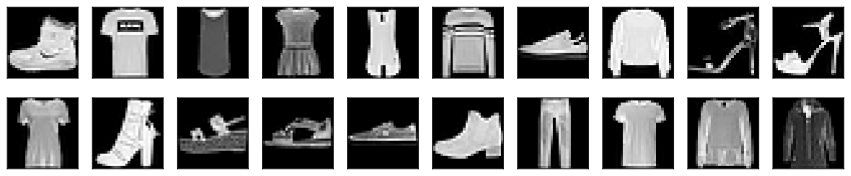

In [15]:
# Print some properties of the dataset.
print('There are', train_loader.dataset.targets.shape[0], 'samples for training and', test_loader.dataset.targets.shape[0], 'samples for testing.')
print()

print('The format of the training data (sample size, image height, image width) is', tuple(train_loader.dataset.data.shape))
print('The format of the testing data (sample size, image height, image width) is', tuple(test_loader.dataset.data.shape))
print()

input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension of our network as a vector is: image height * image width = {}.".format(input_dim))

# Plot 20 example images from the training dataset.
fig=plt.figure(figsize=(15,3))

for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')

plt.show()

## A first architecture
This cell implements a basic neural network with one input layer, one hidden layer, and one output layer.

If you want, you can play around with the number of layers, number of units, weight initialization, dropout, batch normalization, activation functions... this network is your oyster :)

In [16]:
# The class NeuralNet contains everything required to create a neural
# network with the specified architecture.
# It also contains the implementation of the forward pass
# (i.e., calculating the output of the network for some input).

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        # You can find the architecture of your network here:
        # 1 input layer
        self.linear1 = nn.Linear(784, 1024)
        # 1 hidden layers
        self.linear2 = nn.Linear(1024, 512)
        # 1 output layer
        self.linear3 = nn.Linear(512, 10)

        # Adding drop-out to the network to combat overfitting.
        # This is applied to the input and hidden layers.
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.1)

        # Applying batch-normalization after each of the hidden layers.
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)

    # While we have previously defined the components of the network,
    # the forward pass specifies in which order they should be applied to
    # the input (x) in order to arrive at the networks final output.
    def forward(self, x):
        # Input layer: 1 linear layer with dropout and ReLu activation.
        x = self.linear1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.bn1(x)

        # 1 hidden linear layer with dropout and ReLu activation.
        x = self.linear2(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.bn2(x)

        # 1 output layer with log softmax activation.
        x = self.linear3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Defining the training function

This cell defines a function which can be used to train our model.

In [17]:
def train(args, model, device, train_loader, optimizer, epoch,
          loss_curve, flatten_input=False,
          ):

    # We set the "mode" of the model to train, where the weights may be modified.
    model.train()

    # The train loader gives us the batches of data to train on,
    # each batch coming with the image input as well as the target labels (classes).
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the input images (matrix form) into a vector.
        if flatten_input:
          data = Variable(data.view(-1, input_dim))

        # Place the input data and target labels to the GPU.
        data, target = data.to(device), target.to(device)

        #  Set the loss gradients to zero.
        # (So that they do not accumulate across epochs.)
        optimizer.zero_grad()

        # Calculate the output of the network for the given input data.
        output = model(data)

        # Calculate the loss (negative log likelihood loss = cross entropy loss) using the target labels.
        loss = F.nll_loss(output, target)

        # Propagate the loss backward and take a step in the direction
        # specified by the gradients.
        loss.backward()
        optimizer.step()

        # Print a message to show progress of training.
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            # Save the current training loss to display loss curve later.
            loss_curve.append(loss.item())  # added in exercise 1

## Defining the testing function.

This cell defines a function which tests the trained model on the test set.

It prints the average loss and the accuracy.

It also returns the accuracy, as well as a confusion matrix.

In [24]:
optimizer.zero_grad

<bound method Optimizer.zero_grad of SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    momentum: 0.5
    nesterov: False
    weight_decay: 0.0001
)>

In [20]:
def test(args, model, device, test_loader, flatten_input=False):
    # Initialize the confusion matrix as an empty table for 10 classes.
    confusion_matrix = np.zeros([10,10], int)

    # Set the model to evaluation mode.
    model.eval()

    # Initialize variables to store the test loss and number of correct predictions.
    test_loss = 0
    correct = 0

    with torch.no_grad():
        # For every image and target label in the test loader:
        for data, target in test_loader:
            # Flatten the input images (matrix form) into a vector.
            if flatten_input:
              data = Variable(data.view(-1, input_dim))

            # Place data and target labels on GPU.
            data, target = data.to(device), target.to(device)

            # Calculate the output of the network for the given input.
            output = model(data)

            # Accumulate the test loss (negative log likelihood loss) by adding
            # the losses for evey data point in the testing set.
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Get the index (class ID) with the maximum log-probability
            pred = output.max(1, keepdim=True)[1]

            # Add the number of correct predictions to the total score.
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Add the predictions to the confusion matrix.
            for i, t in enumerate(target):
                confusion_matrix[t.item(), pred[i].item()] += 1

    # Calculate the average testing loss.
    test_loss /= len(test_loader.dataset)

    # Calculate accuracy.
    accuracy = correct / len(test_loader.dataset)

    # Print a message with the performance.
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100*accuracy))

    # Return accuracy score and confusion matrix
    return accuracy, confusion_matrix

## Running training and testing

This cell creates the model, trains it on the training set, and evaluates it on the test set.

In [23]:
args.epochs

1

In [21]:
# Call our previously created model class to create the network.
model = NeuralNet().to(device)

# Specify the optimizer which will be used during training.
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum, weight_decay=0.0001)

# Initialize the loss curve as an empty list (losses will be added to this one).
loss_curve = []

# Repeat the training for as many epochs as previously specified.
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch, loss_curve, flatten_input=True)

# Calculate the accuracy on the testing set and save the score along with the confusion matrix.
print()
true_accuracy, confusion_matrix = test(args, model, device, test_loader, flatten_input=True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.541805
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.983577
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.049014
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.590877
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.075095
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.641372
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.177346
Train Epoch: 1 [5600/60000 (9%)]	Loss: 1.571750
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.575695
Train Epoch: 1 [7200/60000 (12%)]	Loss: 0.813778
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.820976
Train Epoch: 1 [8800/60000 (15%)]	Loss: 0.636717
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.291676
Train Epoch: 1 [10400/60000 (17%)]	Loss: 0.468982
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.290568
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.972025
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.476724
Train Epoch: 1 [13600/60000 (23%)]	Loss: 0.510692
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.430808
Train Epoch: 1 [15200/60000 (25%)]	Loss: 0.460156
Train Epoch: 1 [16000/600

## Some further steps...

### Plot the loss curve

This cell plots the training loss curve, i.e., the loss scores during training (calculated on the training set).

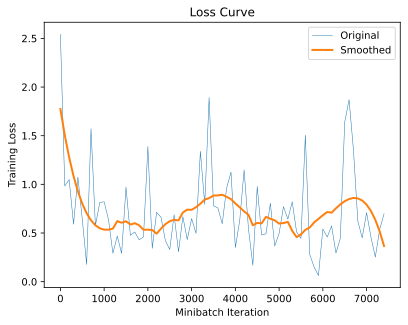

In [25]:
# Calculate the smoothed loss curve (optional).
loss_curve_avg = savgol_filter(loss_curve, len(loss_curve)//3, 3)

# Plot the curves using the Matplotlib library.
plt.plot(args.log_interval*np.arange(len(loss_curve)),loss_curve, label='Original', linewidth=0.5, alpha=1)
plt.plot(args.log_interval*np.arange(len(loss_curve)),loss_curve_avg, label='Smoothed', linewidth=2)
plt.xlabel('Minibatch Iteration')
plt.ylabel('Training Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

### Plot the confusion matrix.

This cell visualizes the confusion matrix, which was calculated on the testing set.

Adding the class names to the plot helps give insight into the type of mistakes the model tends to make, such as: *Which two classses are confused most often? Is that surprising?*

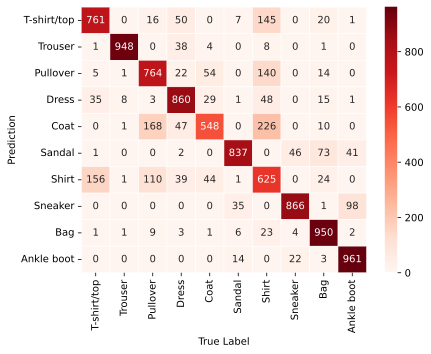

In [26]:
# Store the class labels for the FashionMNIST dataset.
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# We use the Seaborn library to plot the matrix.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.xlabel("True Label")
plt.ylabel("Prediction")
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)
plt.show()

## Saving the model

This section saves the trained model to your Drive, so that you can load it later, if you would like to use it again.

(It also works as a double-check to see if your Drive can properly be connected to Colab, which may be useful in later hands-on sessions as well.)

In [70]:
# Connect (mount) your Drive to Colab
from google.colab import drive

# Your Drive will be found in the content/drive folder here in the runtime of the notebook.
# Once you stop this runtime and close Colab, it will not be connected anymore.
drive.mount('/content/drive')

Mounted at /content/drive


`ATTENTION:` if you wish to specify another path to which to save the model in your drive, you can do that in the next cell.

In [71]:
import os

# The path to the location where you wish to save the model on your Drive.
# Feel free to modify this.
PATH = '/content/drive/MyDrive/aiws25/exercises/solutions/my_first_network.pt'

# Create the folder if it does not exist already.
os.makedirs(os.path.dirname(PATH), exist_ok=True)

# Save the model.
torch.save(model, PATH)

If you later wish to load a model you have previously saved, you can use lines as shown in the next cell.

In [72]:
# Load the model using torch functionality from a specified path.
model = torch.load(PATH)

<ipython-input-72-4da0c2637ab5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(PATH)


**Well done!**

You have just created, trained, evaluated, and saved a neural network!

Now go on to *Part II.* if you feel up to a bit more challenge.

# *Part II.*

## Exercise 1. The difference between train() and test()

The functions `train()` and `test()` look very similar. Have a closer look at them and try to find the main differences between them. What are these parts responsible for? Do you understand why these have to be different in the two functions?

## Exercise 2. Reading the confusion matrix

Can you calculate the accuracy of your model manually, using the confusion matrix from the previous section?

Type your solution in the cell below, and run the cell to check if it is correct.

*Hint: you can check the toal number of data points in the testing set towards the beginning of Part I.*


In [49]:
confusion_matrix
confusion_matrix[1,1]
sum(np.diag(confusion_matrix))/test_loader.dataset.data.shape[0]

AttributeError: 'numpy.ndarray' object has no attribute 'diag'

In [40]:
# Type your solution here, using two decimal places in the percentage format.
# E.g., if you calculated accuracy as 75.82%, type 0.7582.
my_accuracy = sum(np.diag(confusion_matrix))/test_loader.dataset.data.shape[0]

# Printing message confirming your solution.
if my_accuracy == round(true_accuracy, 4):
  print(f"Well done! Accuracy correctly calculated as {my_accuracy*100:.2f}%")

else:
  print(f"Please try again. The true accuracy is {true_accuracy*100:.2f}%, not {my_accuracy*100:.2f}%.")

Well done! Accuracy correctly calculated as 81.20%


## Exercise 3. Load a pre-trained model

As discussed in the intro lecture, there are many deep networks already pre-trained and available in the online ML community. The advantage of these is that they have already been trained on large datasets (e.g., ImageNet, a dataset of 14 million images) and can be used on your own datasets.

Of course, it is often the case that the pre-trained model does not work out-of-the-box on your own dataset (as it was trained on slightly different data). In this case, you have to make slight modifications to your inference process or keep training (fine-tune) the network on your own data.

In this exercise, we have created a convolutional model for you, which was pre-trained on the FashionMNIST dataset, and so should work for predictions completely out-of-the-box.

This model is saved in the file `pretrained_cnn.pt` in the same Drive folder as this notebook. Load this model and test it on FashionMNIST using the previously loaded test set (stored in `test_loader`) and `test()` function. Does it perform better than our first network?

*Hint: the architecture of this convolutional network is defined in the next cell, but its trained weights are saved in a file. Run the next cell before trying to load the model.*



In [50]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolutional Layer 1: input channels = 1 (grayscale), output channels = 32, kernel size = 3x3, padding = 1.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Maxpooling Layer 1: reducing size by 2x2.
        self.pool1 = nn.MaxPool2d(2, 2)

        # Convolutional Layer 2: input channels = 32, output channels = 64, kernel size = 3x3, padding = 1.
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Maxpooling Layer 2: reducing size by 2x2.
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming the input image size is 28x28.
        self.fc2 = nn.Linear(128, 10)  # 10 classes (FashionMNIST)

        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout(p=0.25)  # Apply dropout after the first fully connected layer.
        self.dropout2 = nn.Dropout(p=0.5)   # Apply dropout after the second fully connected layer.

    def forward(self, x):
        # First Convolutional layer followed by Maxpooling and ReLU activation
        x = self.pool1(F.relu(self.conv1(x)))

        # Second Convolutional layer followed by Maxpooling and ReLU activation
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 7 * 7)  # Flatten to a vector of size 64 * 7 * 7

        # First fully connected layer with dropout and ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        # Second fully connected layer with dropout and log_softmax for classification
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

In [75]:
args
test_loader.dataset.data.shape
device
print(model_c)

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)


In [74]:
# Load the model and test in on the previously loaded test set.
PATH_c = '/content/drive/MyDrive/aiws25/exercises/pretrained_cnn.pt'
model_c = torch.load(PATH_c)

# Calculate the accuracy on the testing set and save the score along with the confusion matrix.
print()
true_accuracy_c, confusion_matrix_c = test(args, model_c, device, test_loader)

<ipython-input-74-e336fe13036c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_c = torch.load(PATH_c)



Test set: Average loss: 0.2770, Accuracy: 9067/10000 (90.67%)



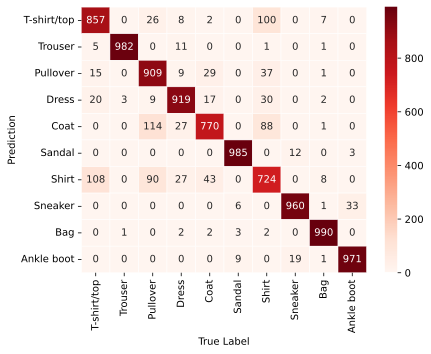

In [76]:
# Plot the confusion matrix for the pre-trained model.

# Store the class labels for the FashionMNIST dataset.
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# We use the Seaborn library to plot the matrix.
ax = sns.heatmap(confusion_matrix_c, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.xlabel("True Label")
plt.ylabel("Prediction")
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)
plt.show()

## Exercise 4. Build your own Convolutional Neural Network (CNN)

In *Part I.*, we created a network with dense linear layers (and some non-linear activations). In *Exercise 3.*, we loaded a pre-trained CNN. Now, let us create our own convolutional network and try to beat that one.

You only have to create a Class of such a network (as you saw in *Part I.*). If you do it correctly, the `train()` and `test()` functions which are already defined should work for your CNN too.

Train and test your CNN to compare its performance with the network used in *Part I* (and with the CNN loaded in *Exercise 2.*).

*Hint 1: feel free to look at the architecture in Exercise 3 and try to improve on it.*

*Hint 2: feel free to also play around with other parameters of training, such as number of epochs or batch size.*

*Hint 3: you can also look at the documentation of the Conv2d layer in PyTorch.*

In [91]:
# Define a class with a new CNN architecture.

class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        # Convolutional Layer 1: input channels = 1 (grayscale), output channels = 32, kernel size = 3x3, padding = 1.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Maxpooling Layer 1: reducing size by 2x2.
        self.pool1 = nn.MaxPool2d(2, 2)

        # Convolutional Layer 2: input channels = 32, output channels = 64, kernel size = 3x3, padding = 1.
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Maxpooling Layer 2: reducing size by 2x2.
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)  # Assuming the input image size is 28x28.
        self.fc2 = nn.Linear(1024, 10)  # 10 classes (FashionMNIST)

        # Dropout layers to prevent overfitting
        self.dropout1 = nn.Dropout(p=0.25)  # Apply dropout after the first fully connected layer.
        self.dropout2 = nn.Dropout(p=0.5)   # Apply dropout after the second fully connected layer.

        # Applying batch-normalization after each of the hidden layers.
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(10)

    def forward(self, x):
        # First Convolutional layer followed by Maxpooling and ReLU activation
        x = self.pool1(F.relu(self.conv1(x)))

        # Second Convolutional layer followed by Maxpooling and ReLU activation
        x = self.pool2(F.relu(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 7 * 7)  # Flatten to a vector of size 64 * 7 * 7

        # First fully connected layer with dropout and ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.bn1(x)

        # Second fully connected layer with dropout and log_softmax for classification
        x = self.fc2(x)
        #x = self.bn2(x)
        x = F.log_softmax(x, dim=1)

        return x

In [84]:
args

namespace(batch_size=8,
          test_batch_size=1000,
          epochs=1,
          lr=0.005,
          momentum=0.5,
          seed=1,
          log_interval=100)

In [92]:
# Train and test this new CNN model on the previously loaded train and test sets.

# Hint: do not forget to initialize the empty loss curve
# (you can peek at the training process in Part I.)

# Call our previously created model class to create the network.
model_c2 = ConvNet2().to(device)

# Specify the optimizer which will be used during training.
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum, weight_decay=0.0001)

# Initialize the loss curve as an empty list (losses will be added to this one).
loss_curve_c2 = []

# Repeat the training for as many epochs as previously specified.
for epoch in range(1, args.epochs + 1):
    train(args, model_c2, device, train_loader, optimizer, epoch, loss_curve)

# Calculate the accuracy on the testing set and save the score along with the confusion matrix.
print()
true_accuracy_c2, confusion_matrix_c2 = test(args, model_c2, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.691325
Train Epoch: 1 [800/60000 (1%)]	Loss: 2.526279
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.329743
Train Epoch: 1 [2400/60000 (4%)]	Loss: 2.059264
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.311197
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.756129
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.493912
Train Epoch: 1 [5600/60000 (9%)]	Loss: 2.838202
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.306654
Train Epoch: 1 [7200/60000 (12%)]	Loss: 2.666124
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.444607
Train Epoch: 1 [8800/60000 (15%)]	Loss: 2.434471
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.322380
Train Epoch: 1 [10400/60000 (17%)]	Loss: 2.418279
Train Epoch: 1 [11200/60000 (19%)]	Loss: 2.605671
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.565025
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.535697
Train Epoch: 1 [13600/60000 (23%)]	Loss: 2.429356
Train Epoch: 1 [14400/60000 (24%)]	Loss: 2.534029
Train Epoch: 1 [15200/60000 (25%)]	Loss: 2.677030
Train Epoch: 1 [16000/600

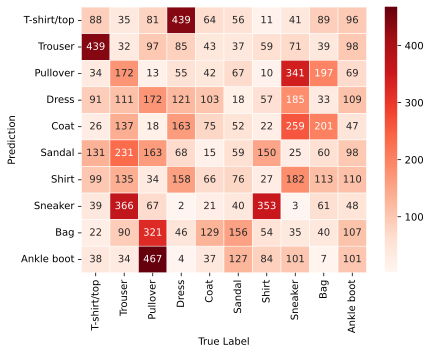

In [93]:
# Plot the confusion matrix for your CNN.


# Plot the confusion matrix for the pre-trained model.

# Store the class labels for the FashionMNIST dataset.
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# We use the Seaborn library to plot the matrix.
ax = sns.heatmap(confusion_matrix_c2, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.xlabel("True Label")
plt.ylabel("Prediction")
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)
plt.show()